In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from astropy.table import Table

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [4]:
file = 'gj1243_tess.dat.fbeye'
colnames = ('Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x')

fbeye = pd.read_table(file, delim_whitespace=True, comment='#', names=colnames)[1:] # skip the first junk row

file2 = 'gj1243_tess15.dat.fbeye'
fbeye2 = pd.read_table(file2, delim_whitespace=True, comment='#', names=colnames)[1:] # skip the first junk row

In [5]:
file = 'tess2019198215352-s0014-0000000273589987-0150-s_lc.fits'

tbl = Table.read(file, format='fits')

q = tbl['QUALITY'] == 0
print(sum(q))

18506


17832


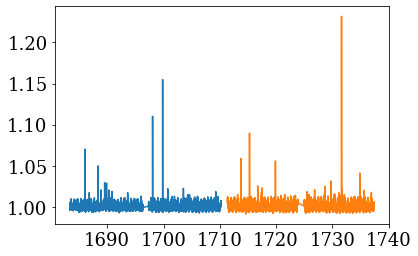

In [6]:
file2 = 'tess2019226182529-s0015-0000000273589987-0151-s_lc.fits'

tbl2 = Table.read(file2, format='fits')

q2 = tbl2['QUALITY'] == 0
print(sum(q2))

plt.plot(tbl['TIME'][q], tbl['PDCSAP_FLUX'][q] / np.nanmedian(tbl['PDCSAP_FLUX'][q]))
plt.plot(tbl2['TIME'][q2], tbl2['PDCSAP_FLUX'][q2] / np.nanmedian(tbl2['PDCSAP_FLUX'][q2]))

In [11]:
dt = np.nanmedian(np.diff(tbl['TIME'][q]))
dt * sum(q)

25.703064112437005

In [12]:
# ED = np.sort(fbeye['Equiv_Dur'].values)[::-1]

ED = np.sort(np.concatenate((fbeye['Equiv_Dur'].values, fbeye2['Equiv_Dur'].values)))[::-1]
# do I need to recalc these? go back and check...

In [13]:
LUMIN =  30.352907 # From my IDL code

TOTDUR = dt * (sum(q) + sum(q2)) # days

ffd_x = np.log10(ED) + LUMIN
ffd_y = np.log10(np.arange(1, len(ED)+1) / TOTDUR)

Text(0.5, 1.0, 'GJ 1243 - TESS Sector 14')

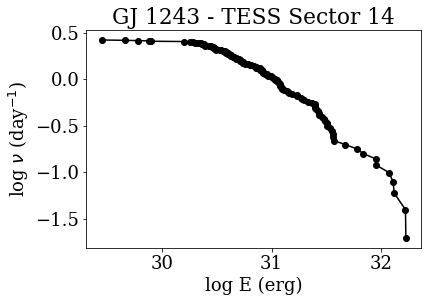

In [14]:
plt.plot(ffd_x, ffd_y, '-o', color='k')

plt.xlabel('log E (erg)')
plt.ylabel(r'log $\nu$ (day$^{-1}$)')
plt.title('GJ 1243 - TESS Sector 14')

In [15]:
E_POINT =  30.037849  # updated version from my IDL Code
#30.665290     #    ;-- from SLH paper

kep_lc = pd.read_table('GJ1243-Flares/data/gj1243_master_slc.dat', delim_whitespace=True, skiprows=1, 
                       names=('time', 'flux', 'error', 'detrended_flux'))
TOTDUR_KEP = len(kep_lc) * 58.0 / 60./60./24.

kep_flares_file = 'GJ1243-Flares/data/gj1243_master_flares.tbl'
kflare = pd.read_table(kep_flares_file, delim_whitespace=True, comment='#',
                       names=('fstart', 'fstop', 'tstart', 'tstop', 'tpeak', 'trise', 'tdecay', 'fpeak', 
                              'ed', 'edrise', 'eddecay', 'cplx_flg', 'ppl1', 'ppl2','npts'))

In [16]:
TOTDUR_KEP

291.4526851851852

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


Text(0.5, 1.0, 'GJ 1243')

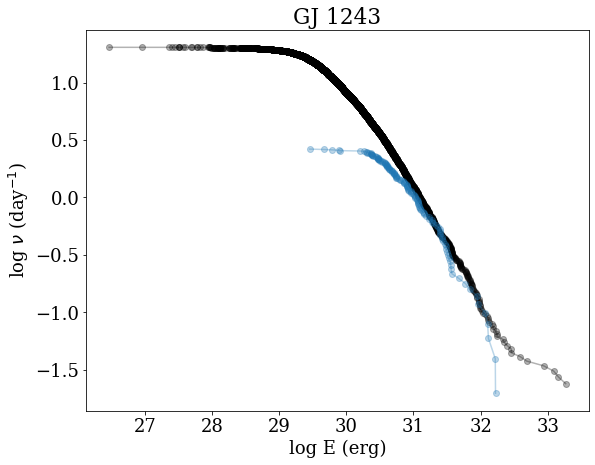

In [42]:
plt.figure(figsize=(9,7))
ffd_xk = np.log10(np.sort(kflare['ed'])[::-1]) + E_POINT
ffd_yk = np.log10(np.arange(1, len(ffd_xk)+1) / TOTDUR_KEP)

plt.plot(ffd_xk, ffd_yk, '-o', color='k', alpha=0.3)
plt.plot(ffd_x, ffd_y, '-o', color='C0', alpha=0.3)

plt.xlabel('log E (erg)')
plt.ylabel(r'log $\nu$ (day$^{-1}$)')
plt.title('GJ 1243')

In [71]:
Perror(10**ffd_yk*TOTDUR_KEP)[1]/TOTDUR_KEP

array([0.00796999, 0.00912091, 0.01007536, ..., 0.27153395, 0.2715559 ,
       0.27157786])

In [87]:
#Error Propagation

#Y errors
def Perror(n):
    err_down = n * (1. - 1. / (9. * n) -1./(3. * np.sqrt(n)))**3 - n
    err_up = n + np.sqrt(n + 0.75) + 1.0 - n 
    return err_down, err_up

_, ffd_yerr = Perror((10**ffd_y) * TOTDUR) / TOTDUR
ffd_yerrk = Perror(10**ffd_yk*TOTDUR_KEP)[1]/TOTDUR_KEP

#X Errors
ss = np.argsort(np.concatenate((fbeye['Equiv_Dur'].values, fbeye2['Equiv_Dur'].values)))[::-1]
ssk = np.argsort(kflare['ed'].values)[::-1]

dur = np.concatenate((fbeye['t_stop'].values-fbeye['t_start'].values, 
                      fbeye2['t_stop'].values-fbeye2['t_start'].values))[ss]
durk = (kflare['tstop'].values-kflare['tstart'].values)[ssk]

flux_err_kep = kep_lc['error'] / np.nanmedian(kep_lc['flux'])
flux_err_tess = tbl['PDCSAP_FLUX_ERR'][q] / np.nanmedian(tbl['PDCSAP_FLUX'][q])

# ffd_xk = np.log10(np.sort(kflare['ed'])[::-1]) + E_POINT
# ffd_yk = np.log10(np.arange(1, len(ffd_xk)+1) / TOTDUR_KEP)

S2N = ED / np.sqrt(ED + (np.nanmedian(flux_err_tess) * dur * 86400.))
S2Nk = kflare['ed'].values[ssk] / np.sqrt(kflare['ed'].values[ssk] + (np.nanmedian(flux_err_kep) * durk * 86400.))

ffd_xerr = np.abs((1./S2N) / np.log(10.) / ED)
ffd_xerrk = np.abs((1./S2Nk) / np.log(10.) / kflare['ed'].values[ssk])


#and finally:
# ffd_xerr = np.abs(( (1./S2N[np.argsort(ED)])[::-1] ) / np.log(10.) / (tess_x -Lo))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


(28, 33.5)

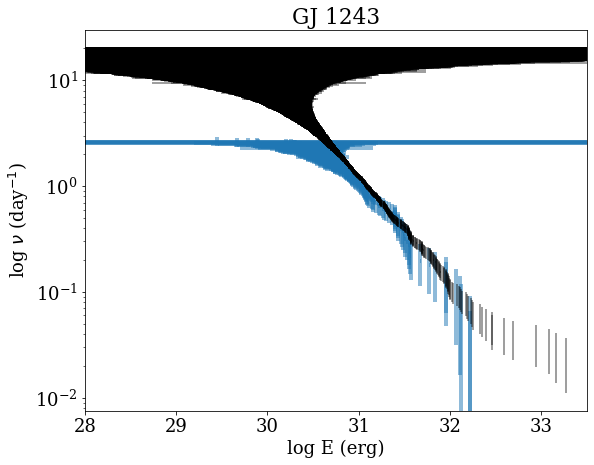

In [98]:
plt.figure(figsize=(9,7))

# plt.plot(ffd_xk, ffd_yk, '-o', color='k', alpha=0.3)
plt.errorbar(ffd_x[0:], (10**ffd_y[0:]), xerr=ffd_xerr[0:], yerr=ffd_yerr[0:], 
             color='C0', alpha=0.5, linestyle='none', lw=4)

plt.errorbar(ffd_xk[0:], (10**ffd_yk[0:]), xerr=ffd_xerrk[0:], yerr=ffd_yerrk[0:], 
             color='k', alpha=0.5, linestyle='none')


plt.yscale('log')

plt.xlabel('log E (erg)')
plt.ylabel(r'log $\nu$ (day$^{-1}$)')
plt.title('GJ 1243')
plt.xlim(28, 33.5)